# IMDB Subwords 8k

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
# import / load data

import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

In [3]:
# separating train/test
train_data, test_data = imdb['train'], imdb['test']

# workaround for adding extra dimensions to data
train_data = train_data.map(lambda x_text, x_label: (x_text, tf.expand_dims(x_label, -1)))
test_data = test_data.map(lambda x_text, x_label: (x_text, tf.expand_dims(x_label, -1)))

In [4]:
# instantiate tokenizer with subwords settings
tokenizer = info.features['text'].encoder

In [5]:
print(tokenizer.subwords)

['the_', ', ', '. ', 'a_', 'and_', 'of_', 'to_', 's_', 'is_', 'br', 'in_', 'I_', 'that_', 'this_', 'it_', ' /><', ' />', 'was_', 'The_', 'as_', 't_', 'with_', 'for_', '.<', 'on_', 'but_', 'movie_', ' (', 'are_', 'his_', 'have_', 'film_', 'not_', 'ing_', 'be_', 'ed_', 'you_', ' "', 'it', 'd_', 'an_', 'he_', 'by_', 'at_', 'one_', 'who_', 'y_', 'from_', 'e_', 'or_', 'all_', 'like_', 'they_', '" ', 'so_', 'just_', 'has_', ') ', 'her_', 'about_', 'out_', 'This_', 'some_', 'ly_', 'movie', 'film', 'very_', 'more_', 'It_', 'would_', 'what_', 'when_', 'which_', 'good_', 'if_', 'up_', 'only_', 'even_', 'their_', 'had_', 'really_', 'my_', 'can_', 'no_', 'were_', 'see_', 'she_', '? ', 'than_', '! ', 'there_', 'get_', 'been_', 'into_', ' - ', 'will_', 'much_', 'story_', 'because_', 'ing', 'time_', 'n_', 'we_', 'ed', 'me_', ': ', 'most_', 'other_', 'don', 'do_', 'm_', 'es_', 'how_', 'also_', 'make_', 'its_', 'could_', 'first_', 'any_', "' ", 'people_', 'great_', 've_', 'ly', 'er_', 'made_', 'r_', 'B

In [6]:
# example of subwords8k encoding

sample_string = 'TensorFlow, from basics to mastery'

tokenized_string = tokenizer.encode(sample_string)
print('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print('The original string: {}'.format(original_string))

Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery


In [7]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y


In [8]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_data.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(train_dataset))

test_dataset = test_data.padded_batch(BATCH_SIZE, tf.compat.v1.data.get_output_shapes(test_data))

In [9]:
# Neural Network design
embedding_dim = 64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(tokenizer.vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 524,237
Trainable params: 524,237
Non-trainable params: 0
_________________________________________________________________


In [10]:
# start training. subwords are much slower in training than full words.
num_epochs = 10

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_data, epochs=num_epochs, validation_data=test_data)

Epoch 1/10
25000/25000 [==============================] - 303s 12ms/step - loss: 0.6863 - accuracy: 0.5250 - val_loss: 0.6868 - val_accuracy: 0.5290
Epoch 2/10
25000/25000 [==============================] - 312s 12ms/step - loss: 0.6839 - accuracy: 0.5344 - val_loss: 0.6862 - val_accuracy: 0.5368
Epoch 3/10
25000/25000 [==============================] - 362s 14ms/step - loss: 0.6829 - accuracy: 0.5397 - val_loss: 0.6863 - val_accuracy: 0.5385
Epoch 4/10
25000/25000 [==============================] - 302s 12ms/step - loss: 0.6821 - accuracy: 0.5420 - val_loss: 0.6865 - val_accuracy: 0.5397
Epoch 5/10
25000/25000 [==============================] - 300s 12ms/step - loss: 0.6816 - accuracy: 0.5432 - val_loss: 0.6869 - val_accuracy: 0.5398
Epoch 6/10
25000/25000 [==============================] - 300s 12ms/step - loss: 0.6813 - accuracy: 0.5436 - val_loss: 0.6874 - val_accuracy: 0.5394
Epoch 7/10
25000/25000 [==============================] - 300s 12ms/step - loss: 0.6810 - accuracy: 0.5441

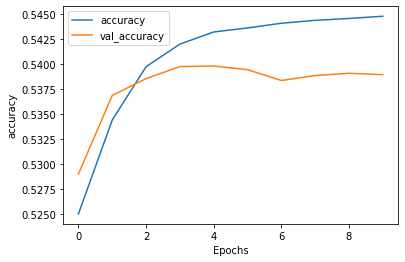

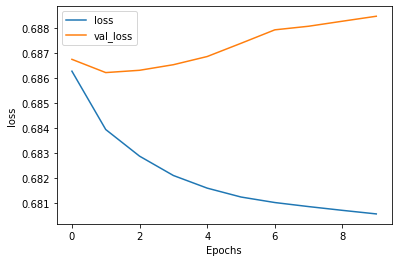

In [11]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [12]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

import io

out_v = io.open('vecs_imdbsubwords.tsv', 'w', encoding='utf-8')
out_m = io.open('meta_imdbsubwords.tsv', 'w', encoding='utf-8')
for word_num in range(1, tokenizer.vocab_size):
  word = tokenizer.decode([word_num])
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()


try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs_imdbsubwords.tsv')
  files.download('meta_imdbsubwords.tsv')

(8185, 64)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

https://projector.tensorflow.org/